In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostRegressor, Pool
from google.cloud import storage
import os
from io import StringIO, BytesIO
from itertools import islice

In [2]:
client = storage.Client()
bucket = client.get_bucket('price-estimation')

In [3]:
blobs = list(bucket.list_blobs(prefix='data/results'))

In [4]:
list(blobs)

[<Blob: price-estimation, data/results/, 1741775413689970>,
 <Blob: price-estimation, data/results/results_all_extras.csv, 1741928390973813>,
 <Blob: price-estimation, data/results/results_drop_extras_and_options.csv, 1741913474783711>,
 <Blob: price-estimation, data/results/results_drop_low_importance.csv, 1741922366361443>,
 <Blob: price-estimation, data/results/results_drop_unpractical.csv, 1742039602086701>,
 <Blob: price-estimation, data/results/results_impute_missing_values.csv, 1742035326630481>,
 <Blob: price-estimation, data/results/results_options.csv, 1741933006996110>,
 <Blob: price-estimation, data/results/results_remove_outliers.csv, 1741910680938105>]

In [5]:
res_dfs = []
for blob in blobs[1:]:
    print(blob.name)
    df_byte = blob.download_as_bytes()
    df = pd.read_csv(BytesIO(df_byte), index_col=0)
    res_dfs.append(df)

data/results/results_all_extras.csv
data/results/results_drop_extras_and_options.csv
data/results/results_drop_low_importance.csv
data/results/results_drop_unpractical.csv
data/results/results_impute_missing_values.csv
data/results/results_options.csv
data/results/results_remove_outliers.csv


In [6]:
linreg = pd.read_csv('../data/experiment_results/linreg_res.csv', index_col=0)
base = pd.read_csv('../data/experiment_results/base_model_res.csv', index_col=0)
res_dfs.append(linreg)
res_dfs.append(base)

In [7]:
list(bucket.list_blobs(prefix='data'))

[<Blob: price-estimation, data/, 1741613897529416>,
 <Blob: price-estimation, data/car_dictionary.pkl, 1741720678485579>,
 <Blob: price-estimation, data/results/, 1741775413689970>,
 <Blob: price-estimation, data/results/results_all_extras.csv, 1741928390973813>,
 <Blob: price-estimation, data/results/results_drop_extras_and_options.csv, 1741913474783711>,
 <Blob: price-estimation, data/results/results_drop_low_importance.csv, 1741922366361443>,
 <Blob: price-estimation, data/results/results_drop_unpractical.csv, 1742039602086701>,
 <Blob: price-estimation, data/results/results_impute_missing_values.csv, 1742035326630481>,
 <Blob: price-estimation, data/results/results_options.csv, 1741933006996110>,
 <Blob: price-estimation, data/results/results_remove_outliers.csv, 1741910680938105>,
 <Blob: price-estimation, data/train_test_sets/, 1741775431478002>,
 <Blob: price-estimation, data/train_test_sets/processed_test_set_ALL_EXTRAS.csv, 1742135751874949>,
 <Blob: price-estimation, data/tra

In [8]:
def load_test_sets():
    client = storage.Client()
    bucket = client.get_bucket('price-estimation')
    blob_test = bucket.get_blob('data/train_test_sets/test_02032024.csv')
    blob_test_processed = bucket.get_blob('data/train_test_sets/processed_test_set_DROP_UNPRACTICAL.csv.csv')
    test_bytes = blob_test.download_as_bytes()
    test_processed_bytes = blob_test_processed.download_as_bytes()
    test = pd.read_csv(BytesIO(test_bytes), index_col=0)
    processed_test = pd.read_csv(BytesIO(test_processed_bytes), index_col=0)
    return test, processed_test

In [9]:
def load_model(name):
    client = storage.Client()
    bucket = client.get_bucket('price-estimation')
    blob_cb = bucket.get_blob(f'models/{name}.cbm')
    cb_name = f"{name}.cbm"
    blob_cb.download_to_filename(cb_name)
    cb = CatBoostRegressor().load_model(cb_name)
    return cb

In [10]:
test, test_processed = load_test_sets()

In [9]:
res_dfs[0].head()

,id,residuals_all_extras,abs_residuals_all_extras,ape_all_extras
97871,343992280,-6303.354826,6303.354826,0.197103
46170,43582010,-1162.602634,1162.602634,0.314217
87214,339418109,117.232165,117.232165,0.016282
86119,338800209,-3405.899315,3405.899315,0.038269
67363,44290997,717.897308,717.897308,0.199416


In [11]:
res_df = pd.concat(res_dfs, axis=1)

In [12]:
cb2 = load_model('catboost_q2')
cb1 = load_model('catboost_q1')
cb3 = load_model('catboost_q3')

In [22]:
cb2.feature_names_

['lat',
 'lon',
 'is_new',
 'mileage',
 'crashed',
 'engine_size',
 'registration_year',
 'engine_power',
 'fuel_type',
 'gearbox_type',
 'brand',
 'model',
 'extra_turbo',
 'extra_steering_lights',
 'extra_collision_avoidance_system',
 'extra_trip_computer',
 'extra_wheelchair',
 'extra_apple_carplay',
 'extra_leather_seats',
 'extra_anti_theft_system_gps',
 'extra_rain_sensor',
 'extra_panoramic_roof',
 'extra_dvd',
 'extra_automatic_parking',
 'extra_multi_purpose_steering_wheel',
 'extra_tcs_asr',
 'extra_tv_camera',
 'extra_power_windows',
 'extra_bucket_seats',
 'extra_hitch',
 'extra_aircondition(a_c)',
 'extra_heated_seats',
 'extra_power_seats',
 'extra_alumium_rims',
 'extra_locking_differential',
 'extra_android_auto',
 'extra_roof_rails',
 'extra_armored',
 'extra_lane_assist',
 'never_crashed',
 'extra_immobilizer',
 'extra_rear_view_camera',
 'extra_air_suspension',
 'extra_bluetooth',
 'extra_parktronic',
 'extra_isofix_children_seats',
 'extra_electric_sunroof',
 'extra

In [13]:
X_test_proc, y_test_proc = test_processed.drop(columns=['raw_price']), test_processed['raw_price']

In [14]:
X_test_proc.select_dtypes(include=['object', 'category', 'int', 'bool']).columns

Index(['is_new', 'crashed', 'fuel_type', 'gearbox_type', 'brand', 'model',
       'extra_turbo', 'extra_steering_lights',
       'extra_collision_avoidance_system', 'extra_trip_computer',
       'extra_wheelchair', 'extra_apple_carplay', 'extra_leather_seats',
       'extra_anti_theft_system_gps', 'extra_rain_sensor',
       'extra_panoramic_roof', 'extra_dvd', 'extra_automatic_parking',
       'extra_multi_purpose_steering_wheel', 'extra_tcs_asr',
       'extra_tv_camera', 'extra_power_windows', 'extra_bucket_seats',
       'extra_hitch', 'extra_aircondition(a_c)', 'extra_heated_seats',
       'extra_power_seats', 'extra_alumium_rims', 'extra_locking_differential',
       'extra_android_auto', 'extra_roof_rails', 'extra_armored',
       'extra_lane_assist', 'never_crashed', 'extra_immobilizer',
       'extra_rear_view_camera', 'extra_air_suspension', 'extra_bluetooth',
       'extra_parktronic', 'extra_isofix_children_seats',
       'extra_electric_sunroof', 'extra_abs', 'extra_teleph

In [15]:
categorical_features = [X_test_proc.columns.get_loc(x) for x in
                          X_test_proc.select_dtypes(include=['object', 'category', 'int', 'bool']).columns.tolist()]

In [16]:
X_test_proc.iloc[:,categorical_features] = X_test_proc.iloc[:,categorical_features].fillna("nan")

In [17]:
test_pool = Pool(data=X_test_proc, label=y_test_proc, cat_features=categorical_features)

In [18]:
res_df = pd.concat([test, res_df], axis=1)

In [32]:
res_df.columns[res_df.columns.str.contains('median')]

Index(['residuals_median', 'abs_residuals_median', 'ape_median'], dtype='object')

In [19]:
res_df['pred_all_extras'] = res_df.raw_price - res_df.residuals_all_extras
res_df['pred_options'] = res_df.raw_price - res_df.residuals_options
res_df['pred_outliers'] = res_df.raw_price - res_df.residuals_remove_outliers
res_df['pred_drop_all'] = res_df.raw_price - res_df.residuals_drop_extras_and_options
res_df['pred_unpractical'] = res_df.raw_price - res_df.residuals_drop_unpractical
res_df['pred_low_importance'] = res_df.raw_price - res_df.residuals_drop_low_importance
res_df['pred_impute_missing'] = res_df.raw_price - res_df.residuals_drop_low_importance

In [20]:
res_df['pe_all_extras'] = res_df.residuals_all_extras/res_df.raw_price
res_df['pe_options'] = res_df.residuals_options/res_df.raw_price
res_df['pe_outliers'] = res_df.residuals_remove_outliers/res_df.raw_price
res_df['pe_drop_all'] = res_df.residuals_drop_extras_and_options/res_df.raw_price
res_df['pe_unpractical'] = res_df.residuals_drop_unpractical/res_df.raw_price
res_df['pe_low_importance'] = res_df.residuals_drop_low_importance/res_df.raw_price
res_df['pe_impute_missing'] = res_df.residuals_impute_missing_values/res_df.raw_price

In [21]:
qs = [0.01, 0.05,0.25,0.5,0.75,0.9, 0.95, 0.99]

In [22]:
ape_cols = [x for x in res_df.columns if 'ape' in x]
abs_res = [x for x in res_df.columns if 'abs' in x]
residuals_cols = [x for x in res_df.columns.drop(abs_res) if 'residuals' in x]

In [25]:
res_df.head()

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,...,pred_unpractical,pred_low_importance,pred_impute_missing,pe_all_extras,pe_options,pe_outliers,pe_drop_all,pe_unpractical,pe_low_importance,pe_impute_missing
97871,37.967795,23.617791,fa2bb5bc-4344-45e4-bedd-f3b6ac023708,False,NaN,Audi A4 '22 S Line 40 TDI Hybrid S tronic 2.0 ...,"{'count': 35, 'urls': ['https://static.car.gr/...",343992280,True,3026721,...,38914.970164,38354.279688,38354.279688,-0.197103,-0.245823,-0.180700,-0.224863,-0.216853,-0.199321,-0.159255
46170,39.561824,21.717647,a7a108e9-5da9-4209-802e-11d1b6864f7b,False,NaN,Skoda Octavia '04 RS TURBO 180 HP,"{'count': 5, 'urls': ['https://static.car.gr/4...",43582010,True,876905,...,4819.354241,4672.012328,4672.012328,-0.314217,-0.312933,-0.309200,-0.345568,-0.302528,-0.262706,-0.326801
87214,40.699982,22.930698,076e678b-5aa3-40e4-89b7-7ace7fd5ff45,False,NaN,Hyundai i 20 '12,"{'count': 32, 'urls': ['https://static.car.gr/...",339418109,True,1010298,...,7084.081217,6816.708420,6816.708420,0.016282,0.042569,0.011423,0.012132,0.016100,0.053235,0.043286
86119,37.881689,23.752999,3e2e94d5-e727-430f-96ae-33fb5b5cdded,False,NaN,"Bmw X6 M '16 AKRAPOVIC,B&O,HUD,SUNROOF,N.VISION","{'count': 84, 'urls': ['https://static.car.gr/...",338800209,False,1000399,...,91335.395269,86454.826010,86454.826010,-0.038269,-0.014637,-0.099719,0.008025,-0.026240,0.028597,-0.018270
67363,40.591626,22.726574,b0b56081-0cf1-4203-9f86-ad94692d6819,False,NaN,Kia Picanto '05,"{'count': 10, 'urls': ['https://static.car.gr/...",44290997,True,1001510490,...,3107.065790,3066.231038,3066.231038,0.199416,0.189298,0.154886,0.193762,0.136926,0.148269,0.141204


In [26]:
ape_res = res_df[[x for x in res_df.columns if 'ape' in x]].mean().to_frame(name="MAPE").reset_index()
med_ape = res_df[[x for x in res_df.columns if 'ape' in x]].median().to_frame(name="MedAPE").reset_index(drop=True)
mae_res = res_df[[x for x in res_df.columns if 'abs_res' in x]].mean().to_frame(name="MAE").reset_index(drop=True)
med_ae = res_df[[x for x in res_df.columns if 'abs_res' in x]].median().to_frame(name="MedAE").reset_index(drop=True)


In [77]:
print(res_df[[x for x in res_df.columns if 'ape' in x]].describe(qs).to_markdown())

|       |   ape_all_extras |   ape_drop_extras_and_options |   ape_drop_low_importance |   ape_drop_unpractical |   ape_impute_missing_values |    ape_options |   ape_remove_outliers |      ape_linreg |     ape_median |
|:------|-----------------:|------------------------------:|--------------------------:|-----------------------:|----------------------------:|---------------:|----------------------:|----------------:|---------------:|
| count |   20286          |               20286           |            20286          |        20286           |             20286           | 20286          |       20286           | 20286           | 20286          |
| mean  |       0.146884   |                   0.149857    |                0.147278   |            0.1477      |                 0.147684    |     0.147313   |           0.153436    |     0.191793    |     0.220556   |
| std   |       0.43854    |                   0.452887    |                0.444773   |            0.435953    |       

In [28]:
importances = cb2.get_feature_importance()

In [29]:
feature_names = cb2.feature_names_

In [114]:
imp = pd.DataFrame({'feature':feature_names,'importances': importances})

In [121]:
print(imp.sort_values(by='importances',ascending=False).to_markdown())

|    | feature                            |   importances |
|---:|:-----------------------------------|--------------:|
|  7 | engine_power                       |   32.3243     |
|  6 | registration_year                  |   16.4626     |
| 11 | model                              |   13.4764     |
|  5 | engine_size                        |   13.2598     |
| 10 | brand                              |    6.19446    |
|  3 | mileage                            |    5.52118    |
|  9 | gearbox_type                       |    3.15257    |
| 74 | rim_size                           |    2.41279    |
| 70 | seats                              |    1.01859    |
| 69 | interior_type                      |    0.728516   |
| 76 | drive_type                         |    0.727837   |
| 77 | doors                              |    0.693719   |
|  4 | crashed                            |    0.349963   |
|  8 | fuel_type                          |    0.319406   |
| 75 | body_type                        

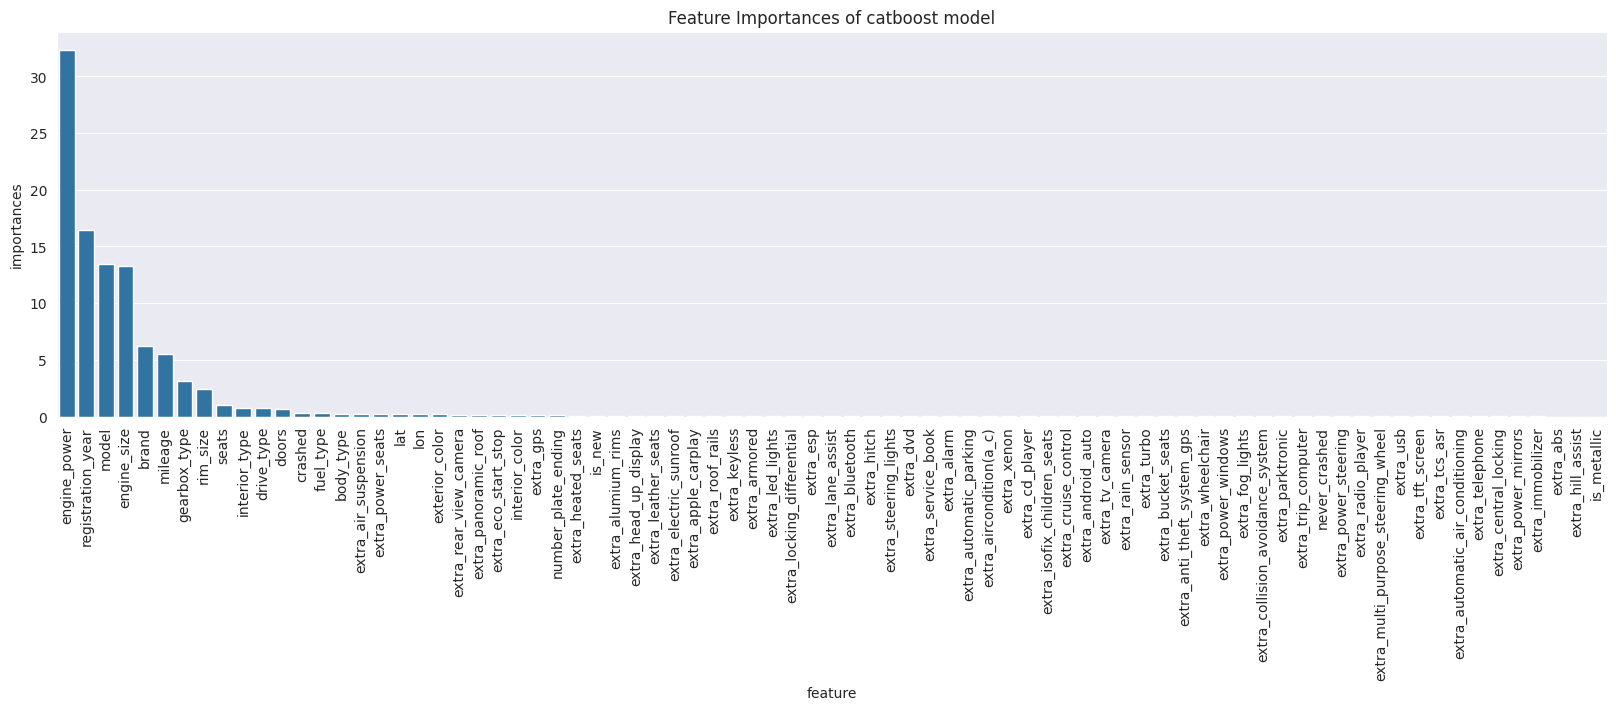

In [133]:
plt.figure(figsize=(20,5))
sns.barplot(x="feature", y="importances", data=imp.sort_values(by='importances',ascending=False))
plt.xticks(rotation=90)
plt.title('Feature Importances of catboost model')
plt.savefig('../plots/feature_importances_catboost.png', bbox_inches='tight')



In [117]:
imp[imp.feature.str.contains('extra')].sum()

feature        extra_turboextra_steering_lightsextra_collisio...
importances                                             2.158297
dtype: object

In [ ]:
plt.figure(figsize=(20,5))
sns.barplot(x="feature", y="importances", data=imp.sort_values(by='importances',ascending=False))
plt.xticks(rotation=90)
plt.title('Feature Importances of catboost model')
plt.savefig('../plots/feature_importances_catboost.png', bbox_inches='tight')



In [109]:
print(pd.concat([ape_res,med_ape, mae_res, med_ae], axis=1).rename(columns={'index':'strategy'}).round(3).to_markdown())

|    | strategy                    |   MAPE |   MedAPE |     MAE |    MedAE |
|---:|:----------------------------|-------:|---------:|--------:|---------:|
|  0 | ape_all_extras              |  0.147 |    0.087 | 1950.77 |  926.606 |
|  1 | ape_drop_extras_and_options |  0.15  |    0.089 | 1971.19 |  950.514 |
|  2 | ape_drop_low_importance     |  0.147 |    0.088 | 1928.97 |  934.133 |
|  3 | ape_drop_unpractical        |  0.148 |    0.089 | 1964.05 |  948.112 |
|  4 | ape_impute_missing_values   |  0.148 |    0.086 | 1925.41 |  925.372 |
|  5 | ape_options                 |  0.147 |    0.088 | 1951.26 |  926.826 |
|  6 | ape_remove_outliers         |  0.153 |    0.089 | 2037.55 |  930.431 |
|  7 | ape_linreg                  |  0.192 |    0.123 | 2682.94 | 1284.06  |
|  8 | ape_median                  |  0.221 |    0.123 | 2740.67 | 1300     |


In [110]:
print(res_df[[x for x in res_df.columns if 'ape' in x]].describe(qs).round(3).to_markdown())

|       |   ape_all_extras |   ape_drop_extras_and_options |   ape_drop_low_importance |   ape_drop_unpractical |   ape_impute_missing_values |   ape_options |   ape_remove_outliers |   ape_linreg |   ape_median |
|:------|-----------------:|------------------------------:|--------------------------:|-----------------------:|----------------------------:|--------------:|----------------------:|-------------:|-------------:|
| count |        20286     |                     20286     |                 20286     |              20286     |                   20286     |     20286     |             20286     |    20286     |    20286     |
| mean  |            0.147 |                         0.15  |                     0.147 |                  0.148 |                       0.148 |         0.147 |                 0.153 |        0.192 |        0.221 |
| std   |            0.439 |                         0.453 |                     0.445 |                  0.436 |                       0.458 | 

In [117]:
print(res_df.loc[(res_df.registration_year > 2008) & (res_df.raw_price > 3000 ) & (res_df.engine_size > 600) & (res_df.raw_price< 100000),['ape_drop_unpractical' ]].describe(qs).to_markdown())

|       |   ape_drop_unpractical |
|:------|-----------------------:|
| count |        14368           |
| mean  |            0.100533    |
| std   |            0.158236    |
| min   |            1.24249e-05 |
| 1%    |            0.00107466  |
| 5%    |            0.00564499  |
| 25%   |            0.0313831   |
| 50%   |            0.0717674   |
| 75%   |            0.131842    |
| 90%   |            0.21271     |
| 95%   |            0.277772    |
| 99%   |            0.480234    |
| max   |           13.2074      |


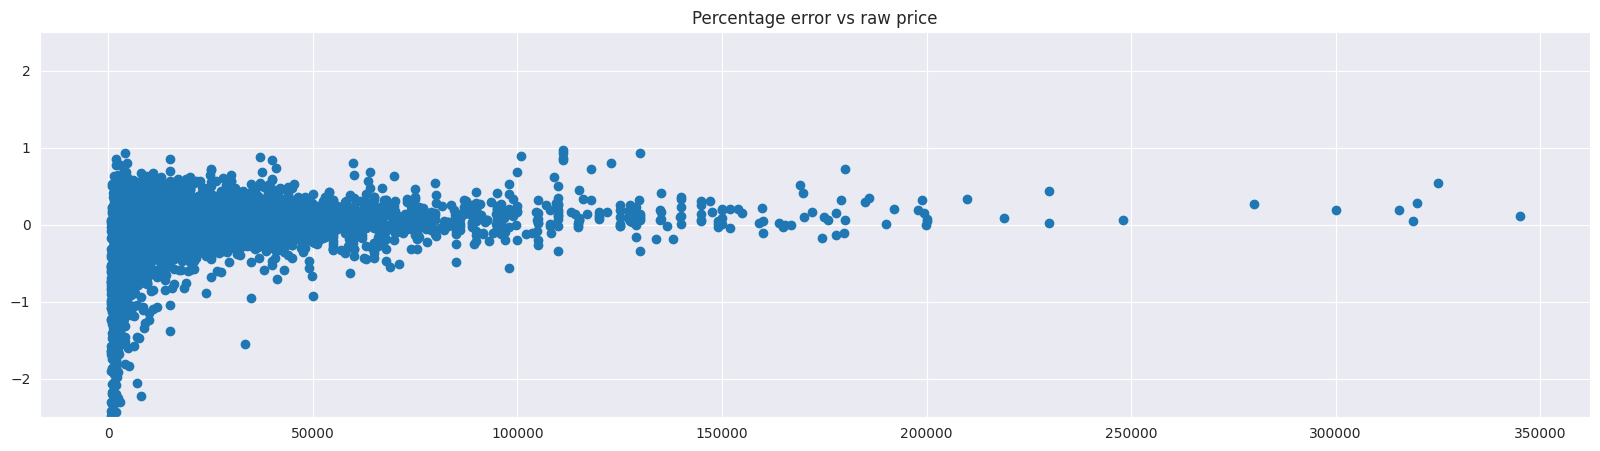

In [36]:
plt.figure(figsize=(20,5))
plt.scatter(res_df['raw_price'], res_df['pe_unpractical'] )

plt.ylim([-2.5,2.5])
plt.title('Percentage error vs raw price')
plt.savefig('../plots/pe_practical_price.png', bbox_inches='tight')


(0.0, 10.0)

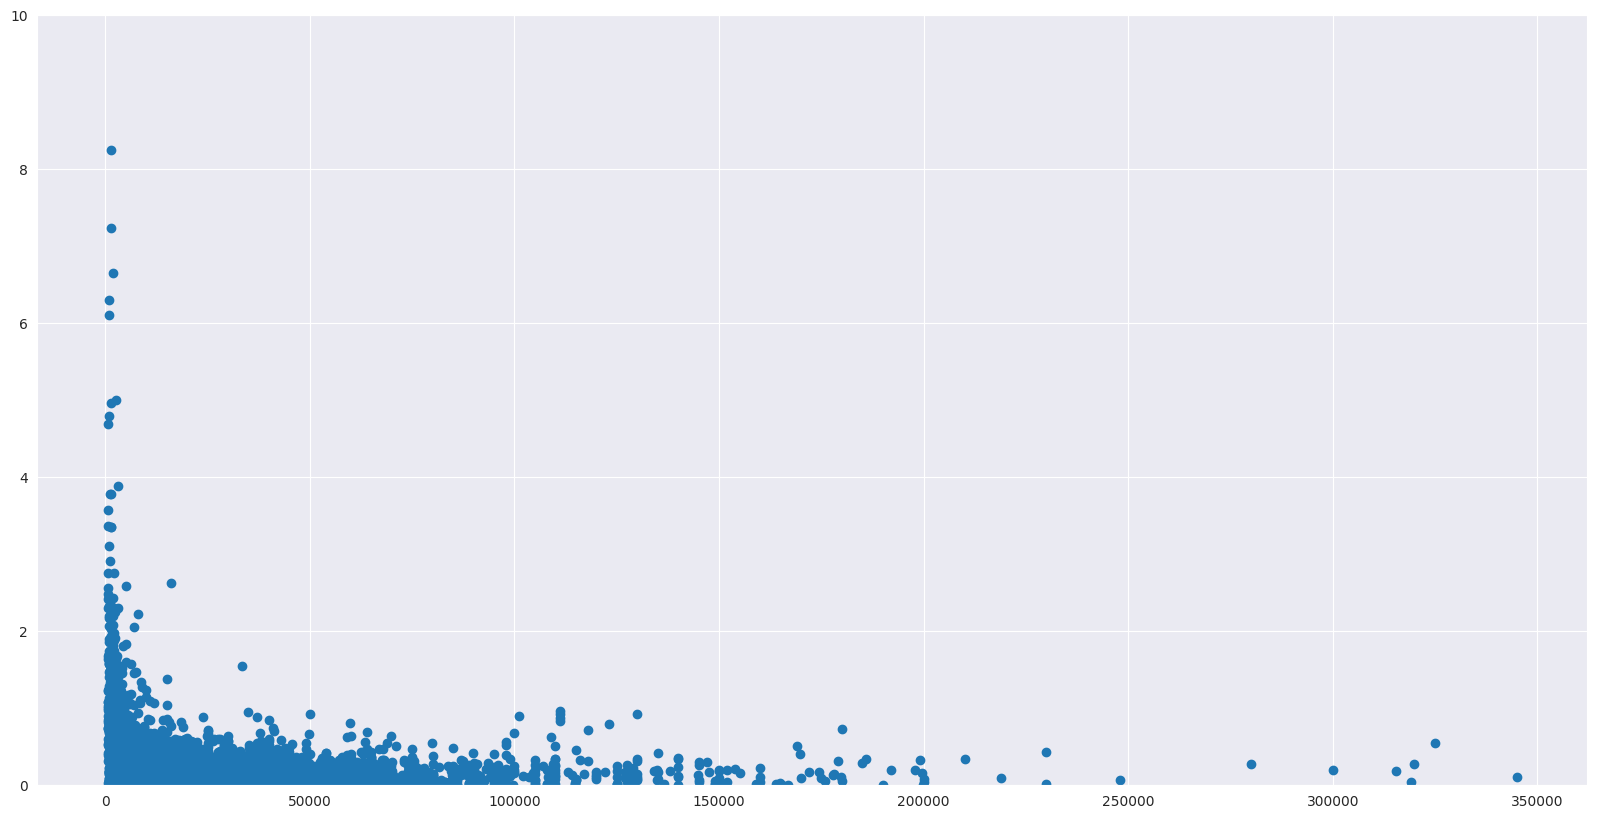

In [40]:
plt.figure(figsize=(20,10))
plt.scatter(res_df['raw_price'], res_df['ape_drop_unpractical'])
plt.ylim([0,10])


In [40]:
# We observe very high overestimation errors for prices close to zero. These points are outliers which are

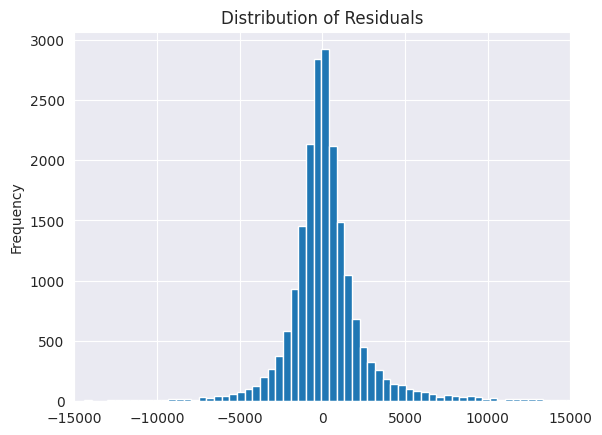

In [42]:
res_df.residuals_drop_unpractical.plot(kind='hist', bins=500)
plt.xlim([-15000,15000])
plt.title('Distribution of Residuals')
plt.savefig('../plots/residuals_drop_unpractical.png', bbox_inches='tight')


In [43]:
from sklearn.metrics import r2_score

In [44]:
1 - (1 - r2_score(res_df.raw_price, res_df.pred_unpractical))*(test.shape[0]-1)/(test.shape[0]- test.shape[1])

0.9199105108786589

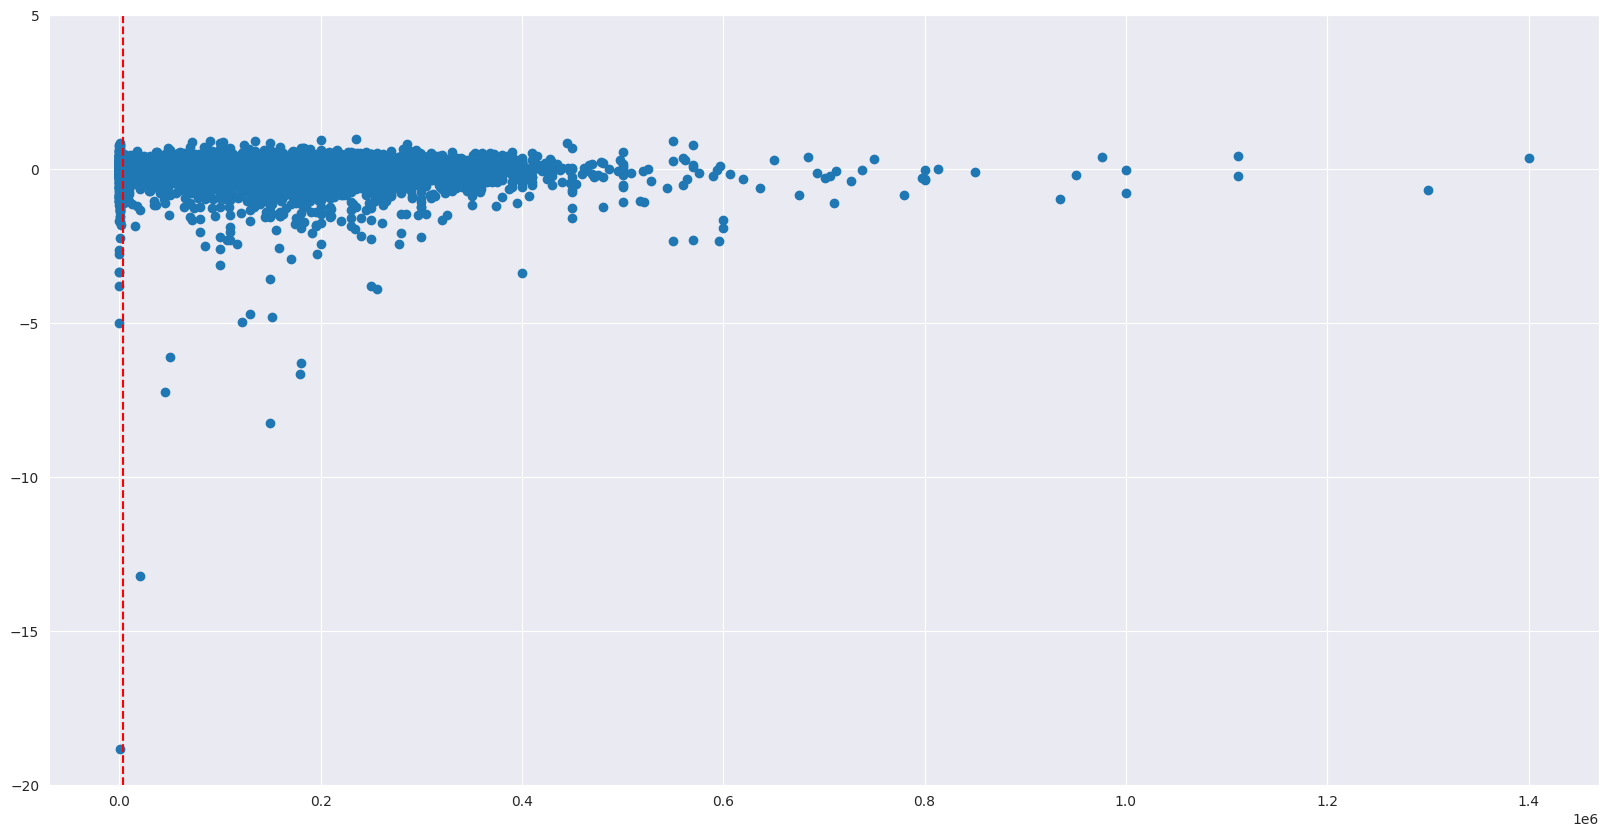

In [46]:
plt.figure(figsize=(20,10))
plt.scatter(res_df['mileage'], res_df['pe_unpractical'])
plt.ylim([-20, 5])
plt.axvline(4000, linestyle='--', color='red')


In [63]:
# again we see a problem regarding cars with very low mileage (under 4000). These points are again outliers

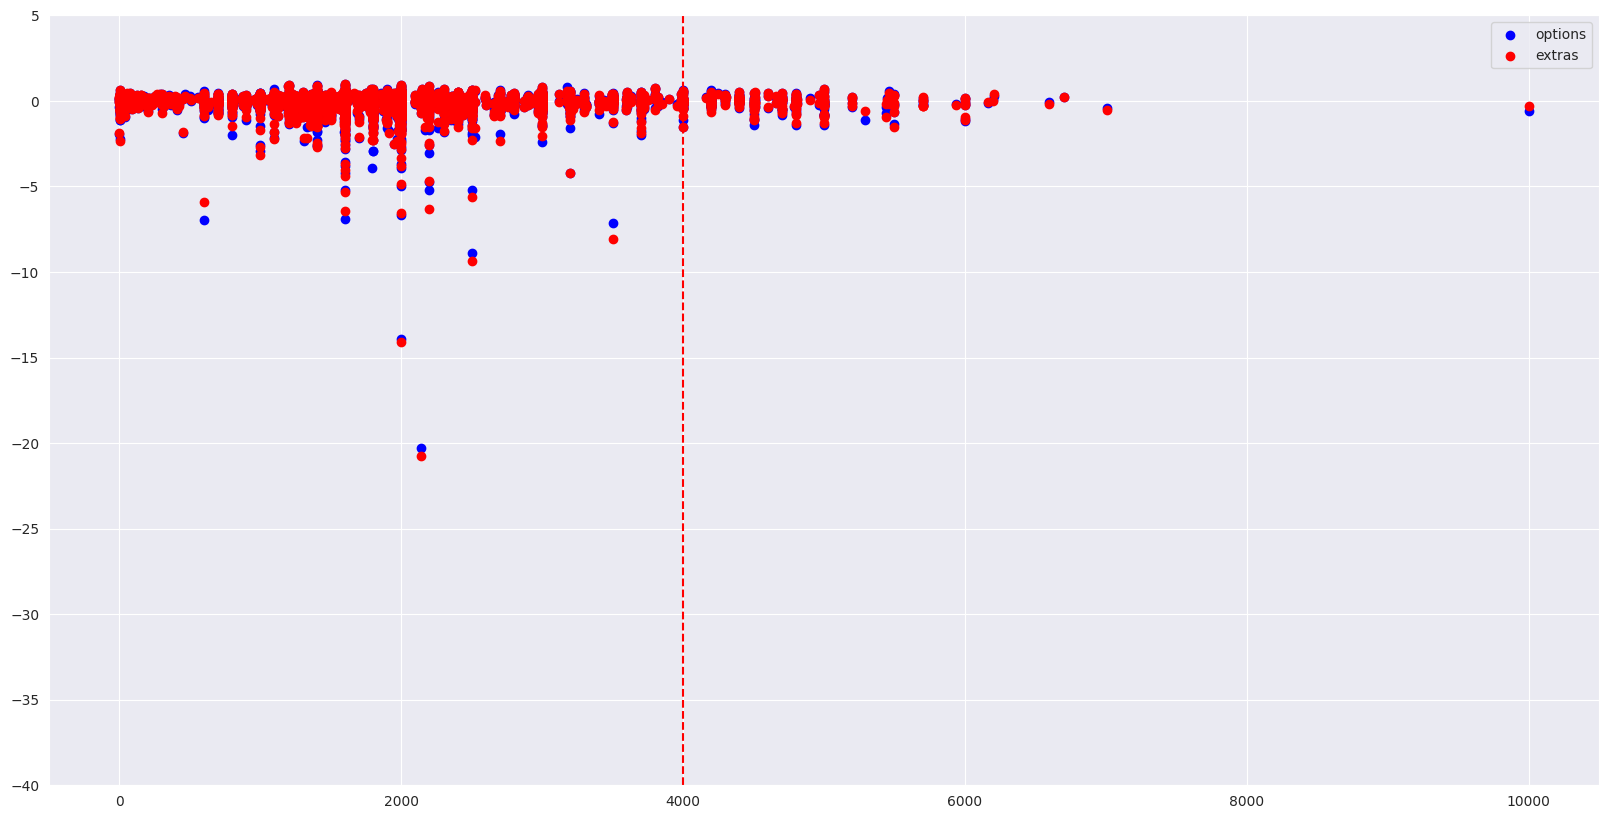

In [45]:
plt.figure(figsize=(20,10))
plt.scatter(res['engine_size'], res['pe_options'], color='blue', label='options' )
plt.scatter(res['engine_size'], res['pe_all_extras'], color='red', label='extras' )
plt.ylim([-40, 5])
plt.axvline(4000, linestyle='--', color='red')
plt.legend()


In [65]:
# here we notice some engine sizes with value 0 which we should have cleaned but realised late.

In [53]:
print(res_df.loc[res_df.ape_drop_unpractical> res_df.ape_drop_unpractical.quantile(.98),['raw_price','registration_year','engine_size','mileage','ape_drop_unpractical']].describe(qs).to_markdown())

|       |   raw_price |   registration_year |   engine_size |   mileage |   ape_drop_unpractical |
|:------|------------:|--------------------:|--------------:|----------:|-----------------------:|
| count |      406    |           406       |       406     |       406 |             406        |
| mean  |     7352.75 |          2006.3     |      1934.07  |    168374 |               1.44206  |
| std   |    19620.9  |             4.63368 |       977.081 |    140922 |               2.67159  |
| min   |      600    |          2001       |         0     |         0 |               0.679464 |
| 1%    |      600    |          2001       |         1     |         0 |               0.681008 |
| 5%    |      700    |          2001       |       824.5   |         1 |               0.688687 |
| 25%   |     1500    |          2003       |      1400     |     80000 |               0.785516 |
| 50%   |     2500    |          2005       |      1800     |    157500 |               0.944885 |
| 75%   | 

(-1.0, 1.0)

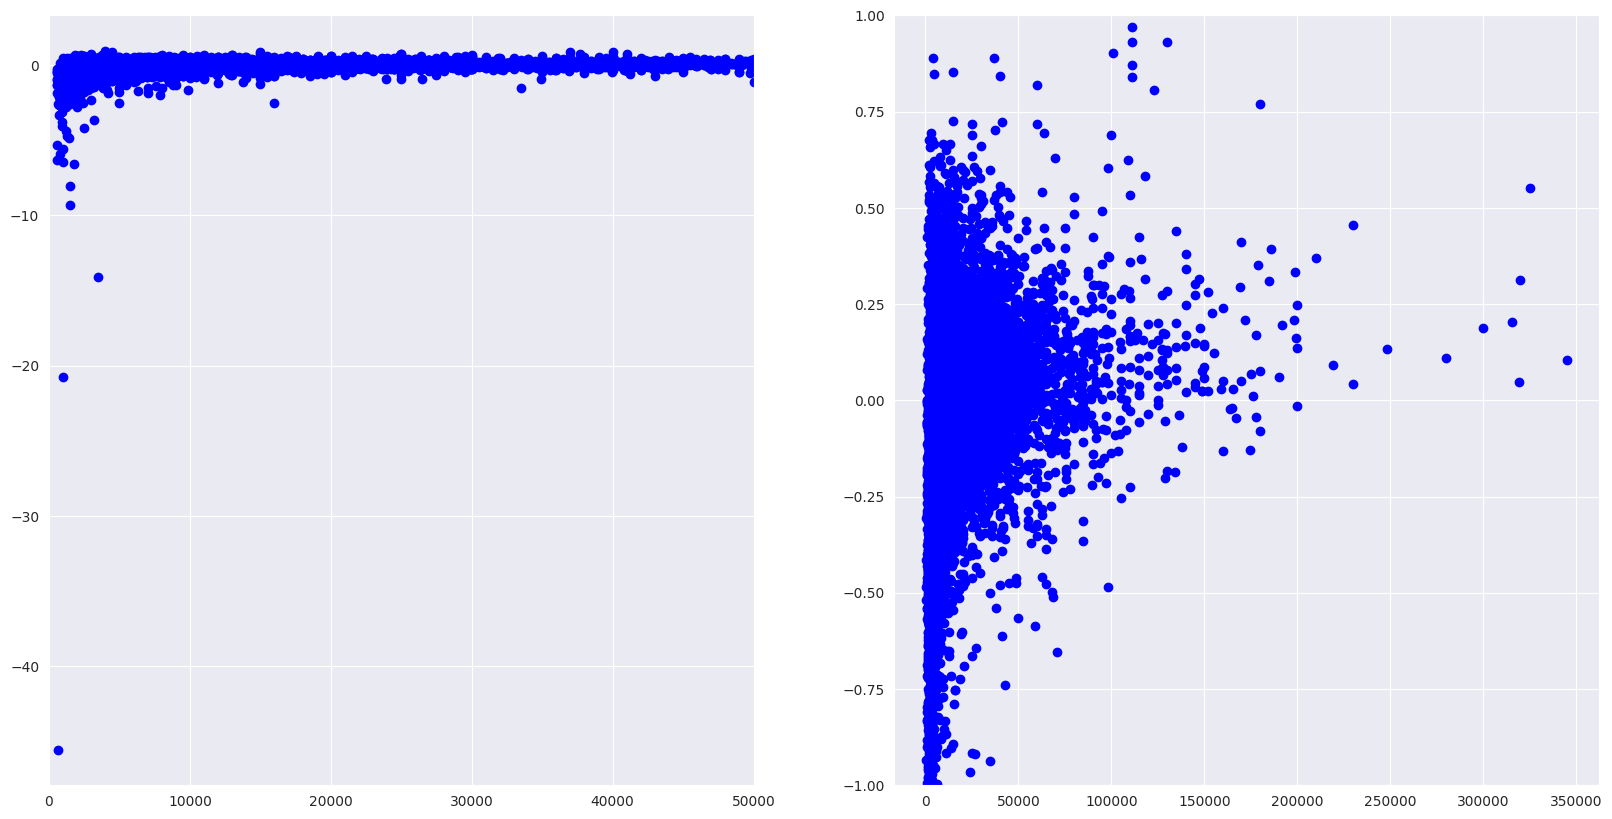

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax[0].scatter(res.raw_price, res.pe_all_extras, color='blue' )
ax[1].scatter(res.raw_price, res.pe_all_extras, color='blue' )
ax[0].set_xlim([0,50000])
ax[1].set_ylim([-1,1])

In [73]:
print(res_df.loc[res_df.ape_all_extras> res_df.ape_all_extras.quantile(.99),['brand','model','registration_year','engine_size','description','raw_price','pred_unpractical','ape_drop_unpractical']].assign(description=res_df['description'].str[:50]).sort_values(by=['ape_drop_unpractical'], ascending=False)[20:30].to_markdown())

|       | brand         | model        |   registration_year |   engine_size | description                                        |   raw_price |   pred_unpractical |   ape_drop_unpractical |
|------:|:--------------|:-------------|--------------------:|--------------:|:---------------------------------------------------|------------:|-------------------:|-----------------------:|
| 95705 | mitsubishi    | pajero pinin |                2004 |          2000 | πωλειται το μοτερ απο αυτο το αυτοκινητο.ειναι σε  |        1200 |            4696.73 |                2.91395 |
| 49505 | volkswagen    | polo         |                2001 |          1400 | θελει μαζεματα.κτεο και σημα του 2025              |         650 |            2441.63 |                2.75636 |
| 43440 | skoda         | octavia      |                2012 |          1600 | σε αριστη κατασταση με ολα του τα service δεκτος κ |        2000 |            7501.5  |                2.75075 |
| 62962 | mercedes-benz | vito         |

In [74]:
cb2.get_params()

{'random_strength': 0.01199857498,
 'verbose': 50,
 'iterations': 11333,
 'nan_mode': 'Max',
 'bagging_temperature': 0.8319957516,
 'grow_policy': 'Depthwise',
 'l2_leaf_reg': 0.6747582331,
 'loss_function': 'Quantile:alpha=0.5',
 'task_type': 'GPU',
 'depth': 9,
 'min_data_in_leaf': 92,
 'learning_rate': 0.02721930604}

In [77]:
print(pd.concat([res_df.loc[res_df.extra_turbo.isna(),'ape_drop_unpractical'].describe(qs), res_df.loc[res_df.extra_turbo.notna(),'ape_drop_unpractical'].describe(qs)],axis=1).round(3).to_markdown())

|       |   ape_drop_unpractical |   ape_drop_unpractical |
|:------|-----------------------:|-----------------------:|
| count |               3834     |              16452     |
| mean  |                  0.21  |                  0.133 |
| std   |                  0.396 |                  0.444 |
| min   |                  0     |                  0     |
| 1%    |                  0.002 |                  0.001 |
| 5%    |                  0.01  |                  0.007 |
| 25%   |                  0.054 |                  0.036 |
| 50%   |                  0.123 |                  0.083 |
| 75%   |                  0.239 |                  0.159 |
| 90%   |                  0.429 |                  0.275 |
| 95%   |                  0.617 |                  0.375 |
| 99%   |                  1.464 |                  0.794 |
| max   |                 13.207 |                 47.185 |


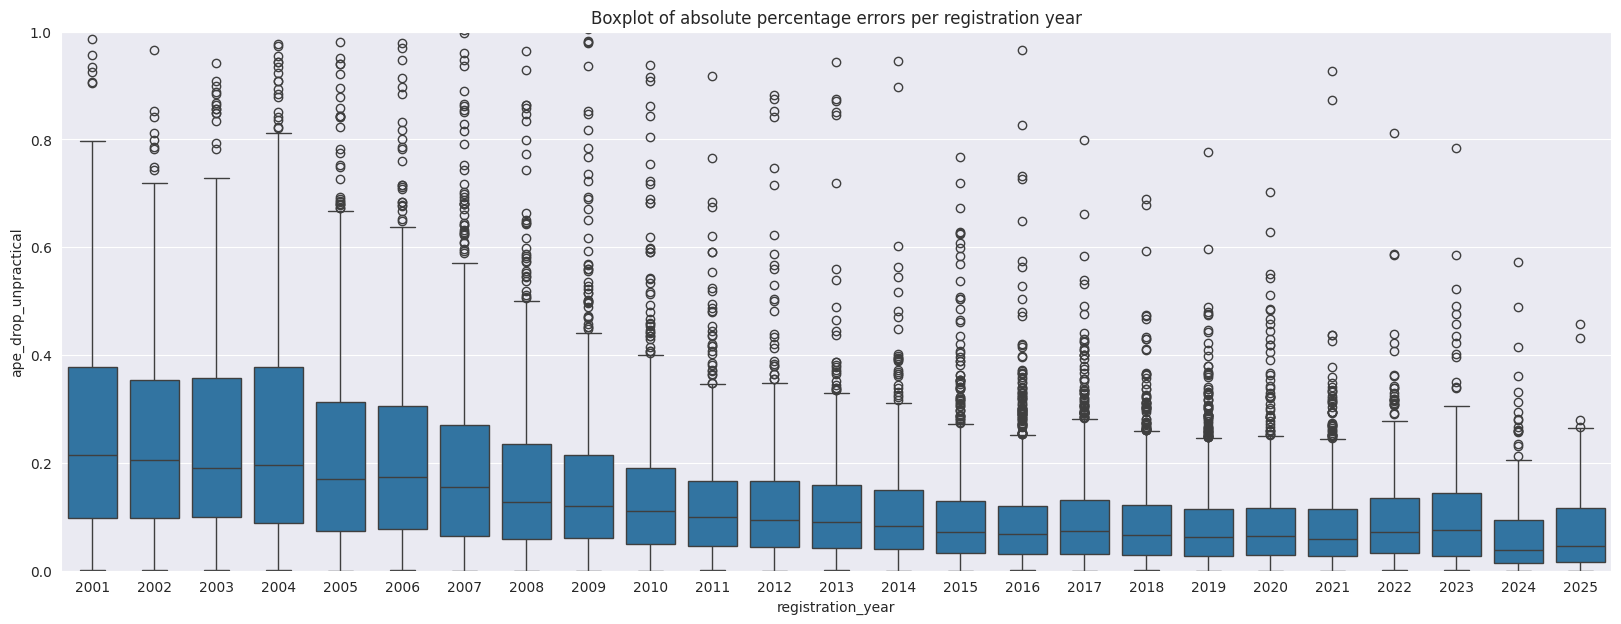

In [88]:
plt.figure(figsize=(20,7))
sns.boxplot(data=res_df, x='registration_year', y='ape_drop_unpractical')
plt.ylim([0,1])
plt.title('Boxplot of absolute percentage errors per registration year')
plt.savefig('../plots/ape_practical_box_year.png', bbox_inches='tight')


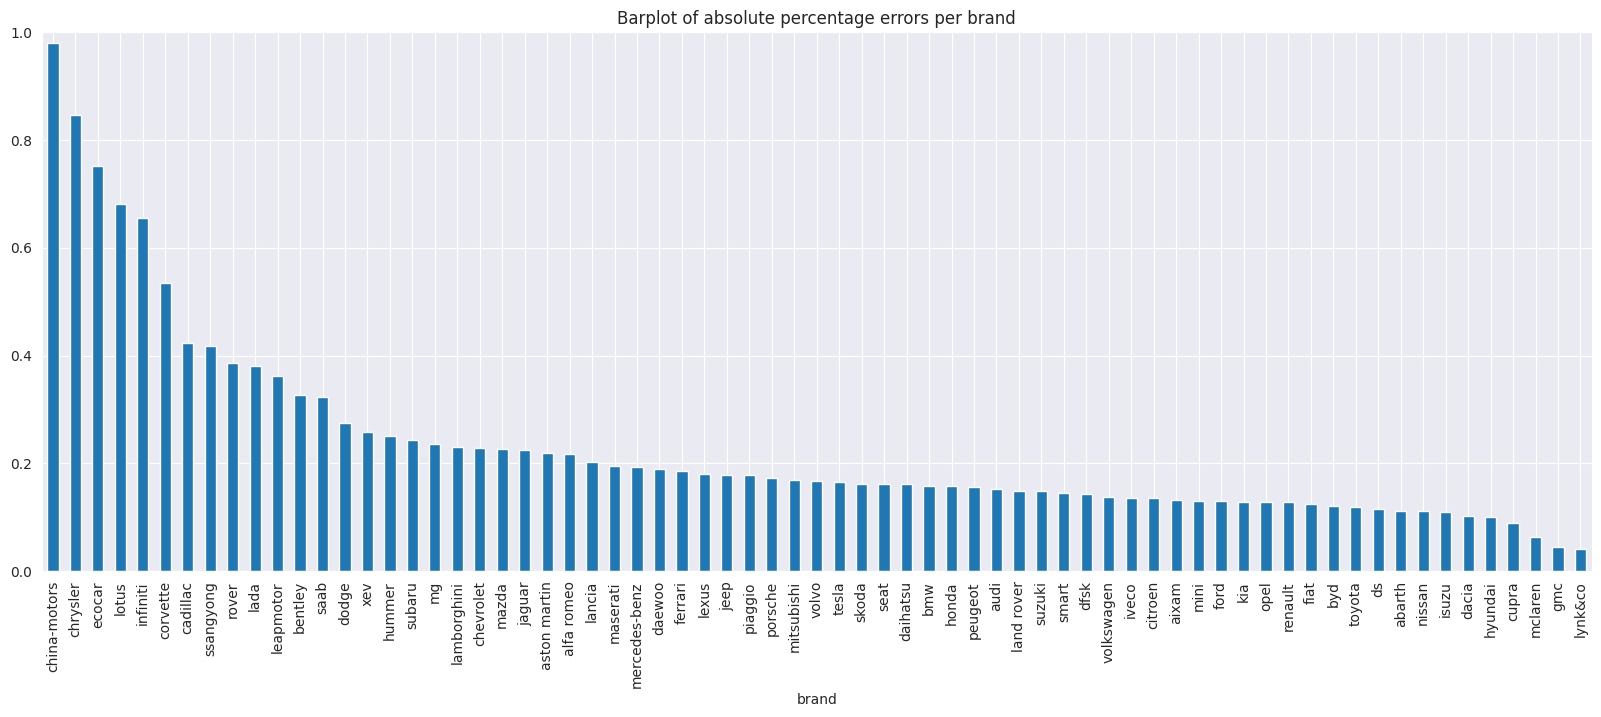

In [89]:
plt.figure(figsize=(20,7))
res_df.groupby(by='brand')['ape_drop_unpractical'].agg('mean').sort_values(ascending=False).plot(kind='bar')
plt.ylim([0,1])
plt.title('Barplot of absolute percentage errors per brand')
plt.savefig('../plots/ape_practical_bar_brand.png', bbox_inches='tight')


In [96]:
res_df['model_count'] = res_df.groupby(by='model')['raw_price'].transform('count')
res_df['model_year_count'] = res_df.groupby(by=['model','registration_year'])['raw_price'].transform('count')

<Axes: ylabel='Frequency'>

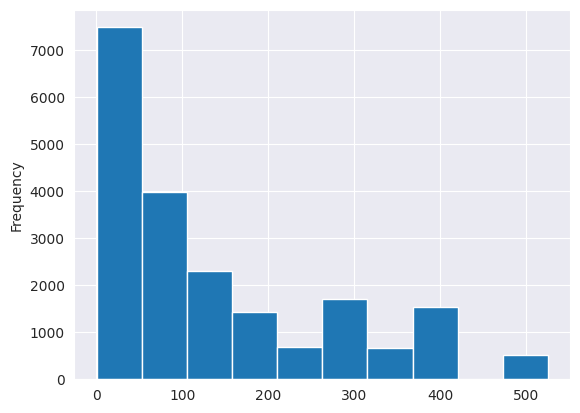

In [93]:
res_df.model_count.plot(kind='hist')

(0.0, 5.0)

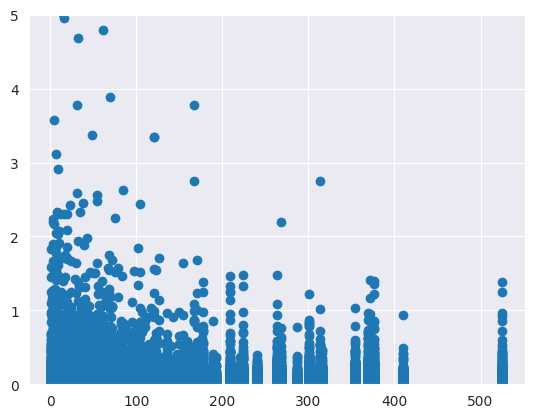

In [94]:
plt.scatter(res_df.model_count, res_df.ape_drop_unpractical)
plt.ylim([0,5])

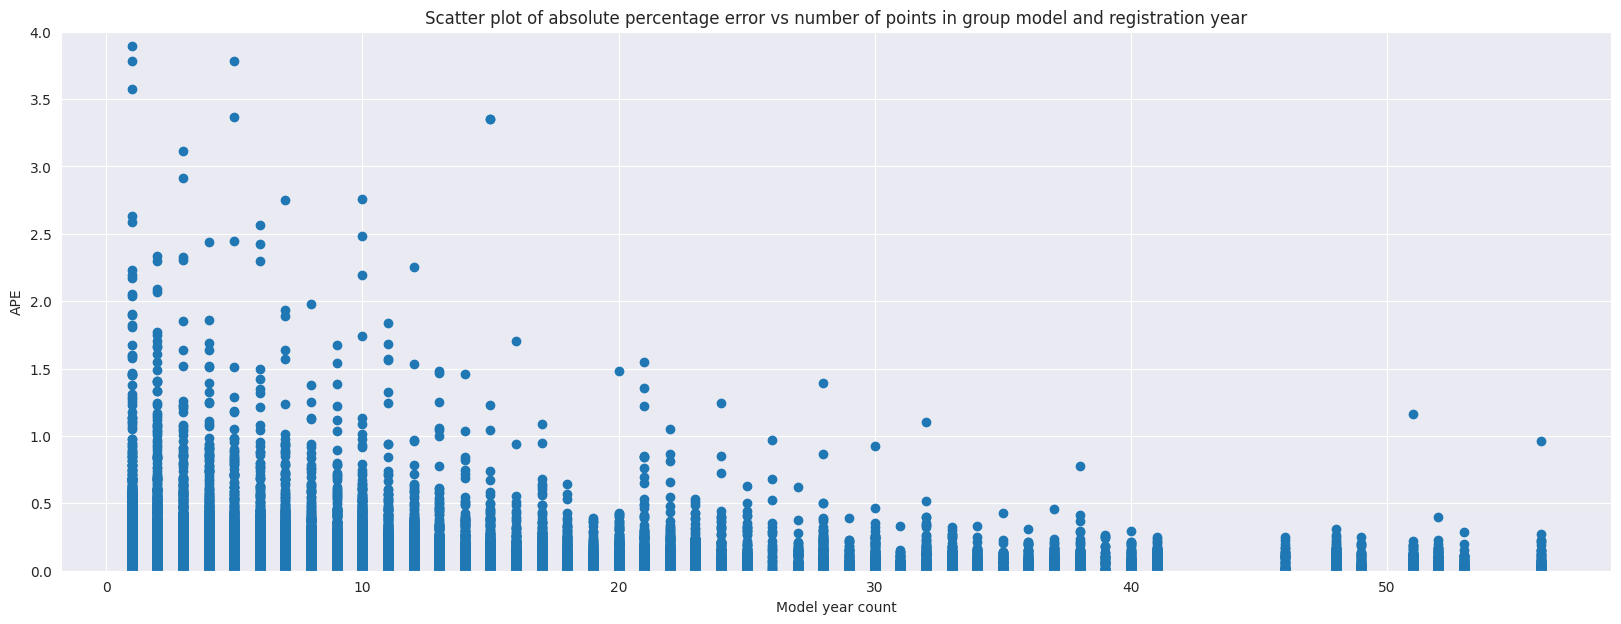

In [101]:
plt.figure(figsize=(20,7))
plt.scatter(res_df.model_year_count, res_df.ape_drop_unpractical)
plt.ylim([0,4])
plt.xlabel('Model year count')
plt.ylabel('APE')
plt.title('Scatter plot of absolute percentage error vs number of points in group model and registration year')
plt.savefig('../plots/scatter_group_count.png', bbox_inches='tight')

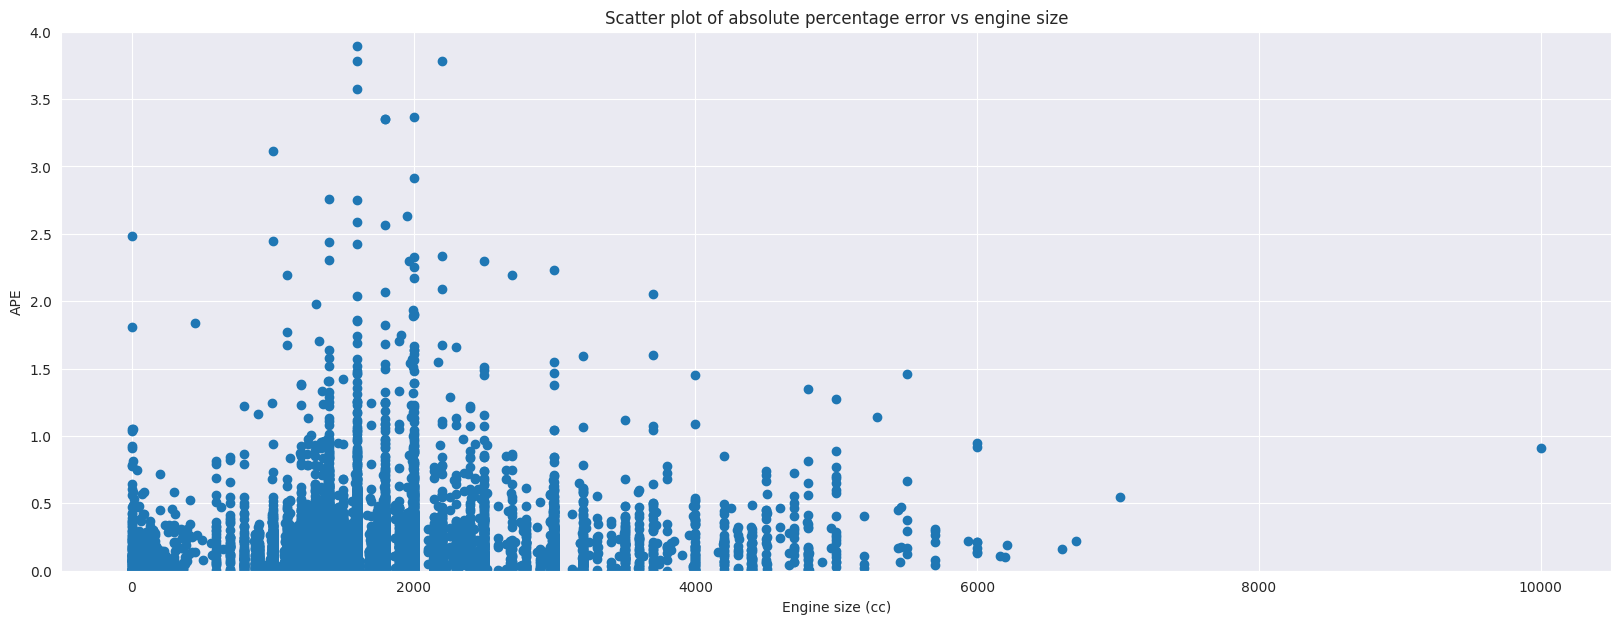

In [102]:
plt.figure(figsize=(20,7))
plt.scatter(res_df.engine_size, res_df.ape_drop_unpractical)
plt.ylim([0,4])
plt.xlabel('Engine size (cc)')
plt.ylabel('APE')
plt.title('Scatter plot of absolute percentage error vs engine size')
plt.savefig('../plots/scatter_engine_size_ape.png', bbox_inches='tight')

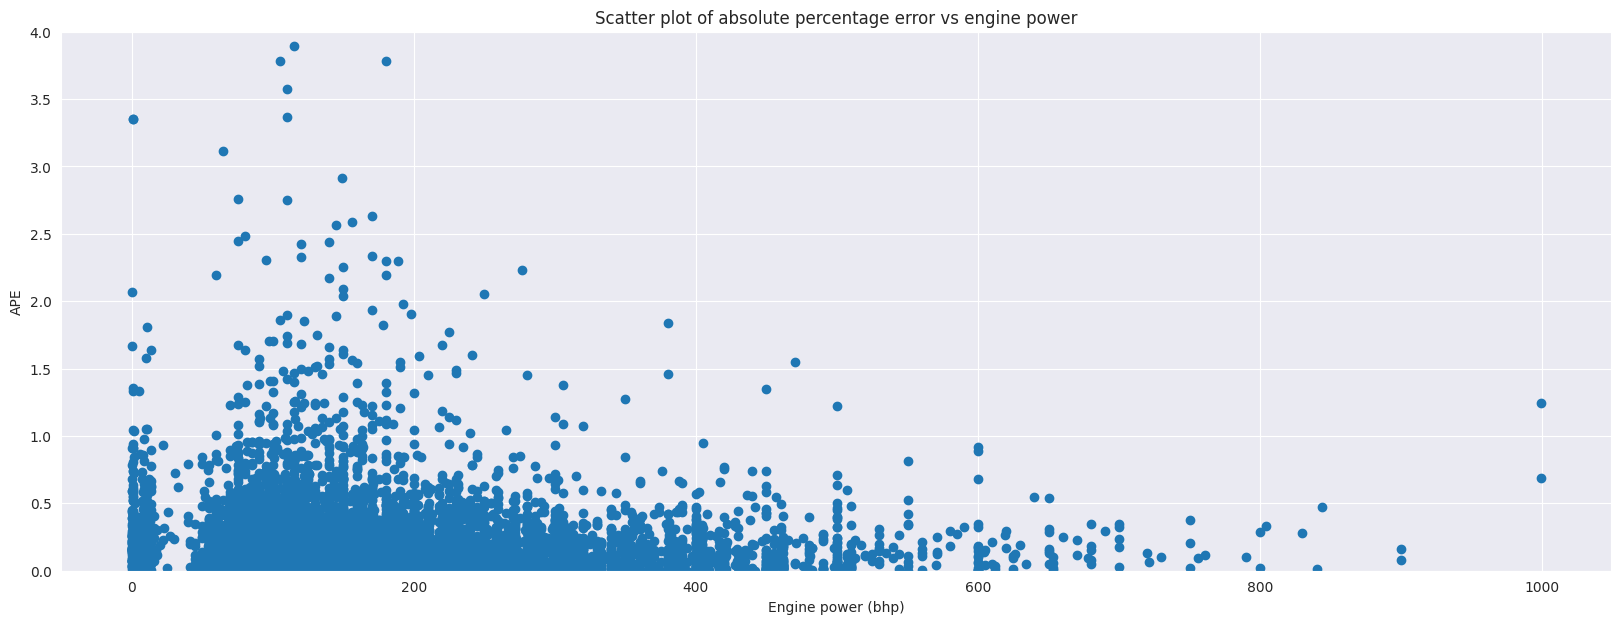

In [103]:
plt.figure(figsize=(20,7))
plt.scatter(res_df.engine_power, res_df.ape_drop_unpractical)
plt.ylim([0,4])
plt.xlabel('Engine power (bhp)')
plt.ylabel('APE')
plt.title('Scatter plot of absolute percentage error vs engine power')
plt.savefig('../plots/scatter_engine_power_ape.png', bbox_inches='tight')

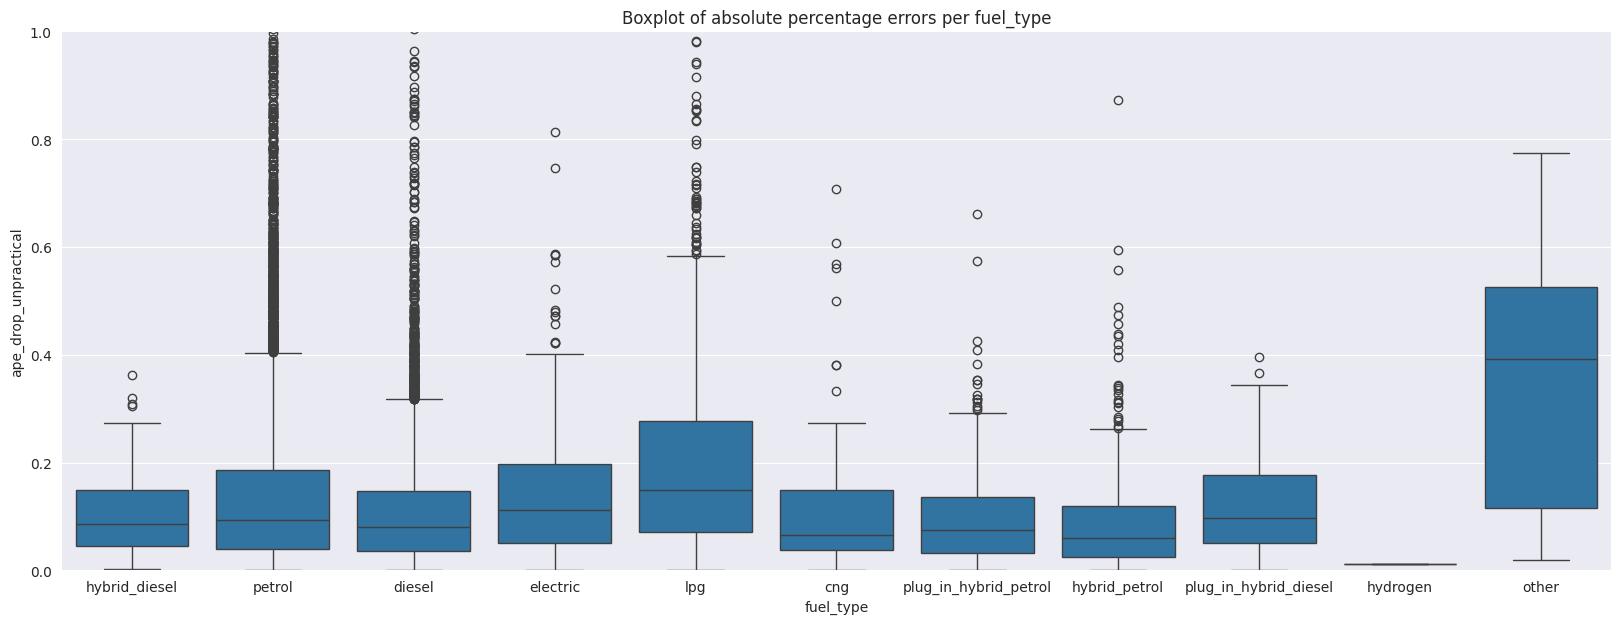

In [104]:
plt.figure(figsize=(20,7))
sns.boxplot(data=res_df, x='fuel_type', y='ape_drop_unpractical')
plt.ylim([0,1])
plt.title('Boxplot of absolute percentage errors per fuel_type')
plt.savefig('../plots/ape_practical_box_fuel.png', bbox_inches='tight')


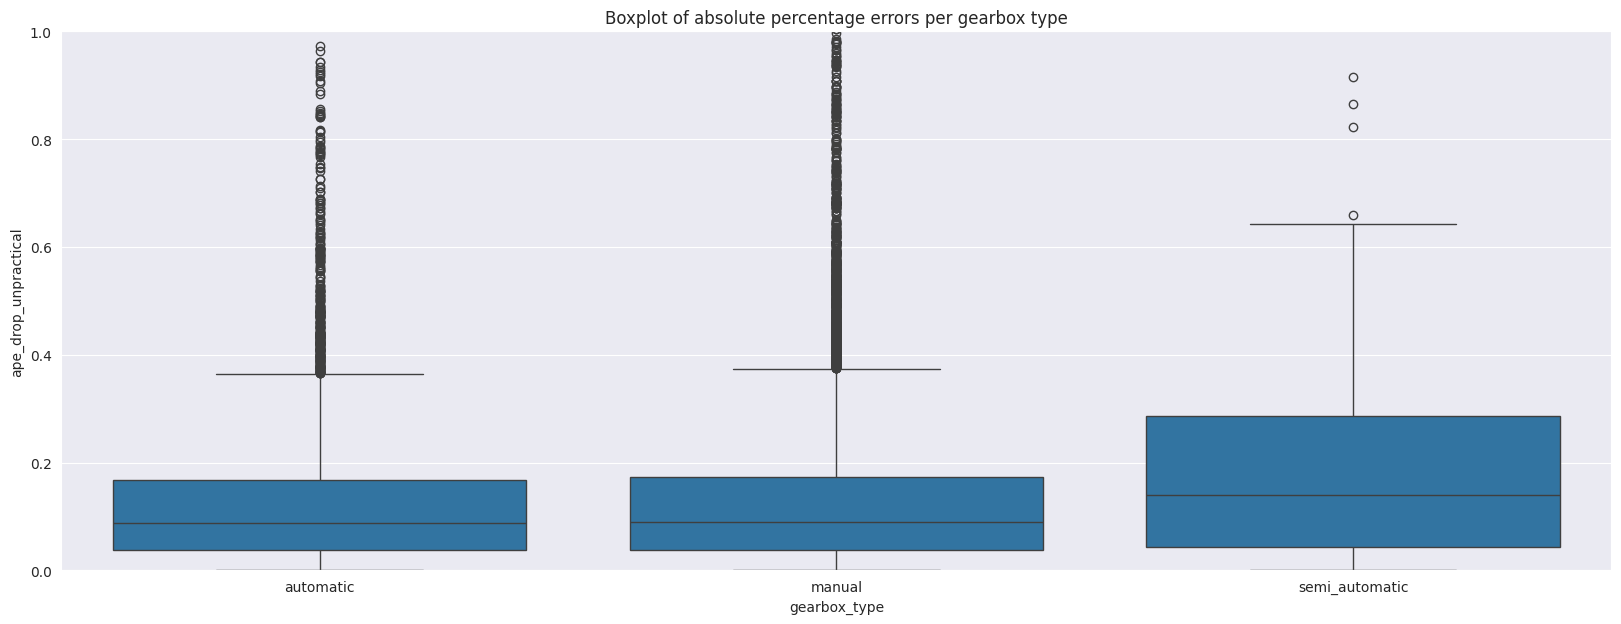

In [105]:
plt.figure(figsize=(20,7))
sns.boxplot(data=res_df, x='gearbox_type', y='ape_drop_unpractical')
plt.ylim([0,1])
plt.title('Boxplot of absolute percentage errors per gearbox type')
plt.savefig('../plots/ape_practical_box_gearbox.png', bbox_inches='tight')


(0.0, 1000000.0)

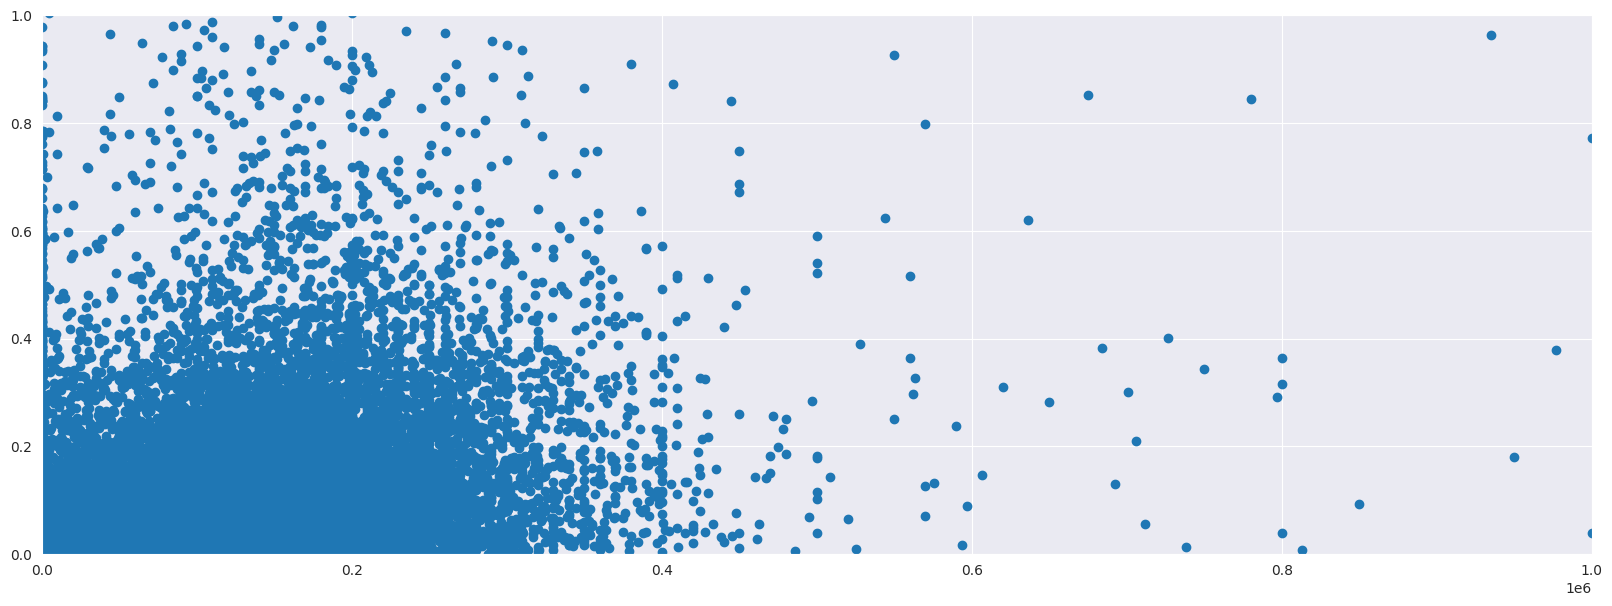

In [110]:
plt.figure(figsize=(20,7))
plt.scatter(res_df.mileage, res_df.ape_drop_unpractical)
plt.ylim([0,1])
plt.xlim(0,1000000)

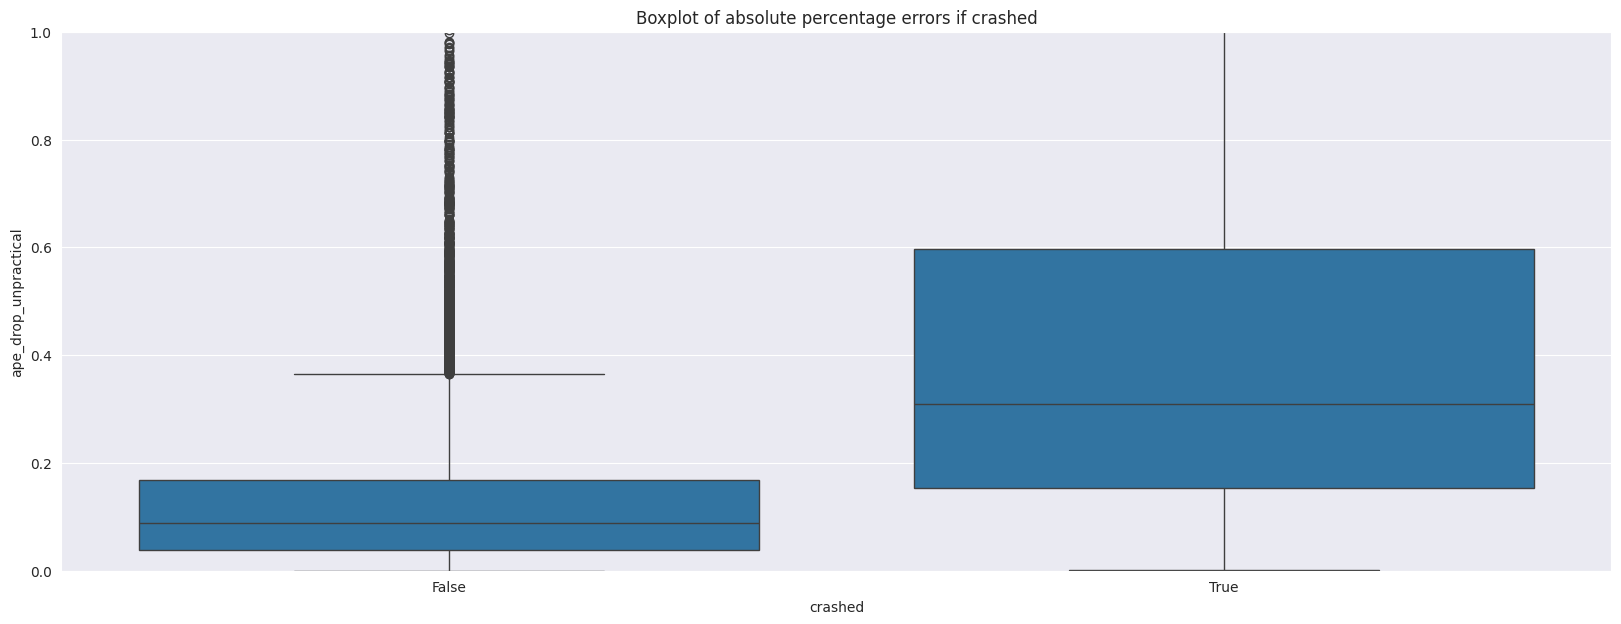

In [107]:
plt.figure(figsize=(20,7))
sns.boxplot(data=res_df, x='crashed', y='ape_drop_unpractical')
plt.ylim([0,1])
plt.title('Boxplot of absolute percentage errors if crashed')
plt.savefig('../plots/ape_practical_box_crashed.png', bbox_inches='tight')


In [112]:
print(res_df.loc[
    (res_df.engine_power > 50) &
    (res_df.raw_price > 2000) &
    (res_df.mileage > 5000 ) &
    (res_df.raw_price < 150000) &
    (~res_df.crashed) &
    (res_df.registration_year > 2008) &
    (~res_df.registration_year.isin(['lpg','cng','hydrogen''other'])), 'ape_drop_unpractical'
].describe(qs).to_markdown())

|       |   ape_drop_unpractical |
|:------|-----------------------:|
| count |        13864           |
| mean  |            0.099785    |
| std   |            0.155323    |
| min   |            1.24249e-05 |
| 1%    |            0.00109708  |
| 5%    |            0.00592297  |
| 25%   |            0.0318868   |
| 50%   |            0.0722225   |
| 75%   |            0.131778    |
| 90%   |            0.211244    |
| 95%   |            0.274392    |
| 99%   |            0.46893     |
| max   |           13.2074      |


In [6]:
def impute_object_col_on_group(group):
    if group.isna().sum() == group.shape[0]:
        return np.nan
    else:
        return group.mode()[0] if not group.mode().empty else np.nan

def impute_num_on_group(group):
    if group.isna().sum() == group.shape[0]:
        return np.nan
    else:
        return group.mean()[0] if not group.mean().empty else np.nan




In [40]:
def impute_missing_values(df, feature):
    #if object select majority among group, for groups only with nan go one level higher
    df = df.copy()

    if df.loc[df[feature].notna(),feature].dtype in ['object', 'bool','Int64', 'category']:
        print(df[feature].isna().sum())
        df[f'mode_{feature}'] = df.groupby(['brand','model','registration_year'])[feature].transform(impute_object_col_on_group)
        df.loc[df[feature].isna(),feature] = df.loc[df[feature].isna(),f'mode_{feature}'].drop(columns=[f'mode_{feature}'])
        print(df[feature].isna().sum())
        df[f'mode_{feature}'] = df.groupby(['brand','model'])[feature].transform(impute_object_col_on_group)
        df.loc[df[feature].isna(),feature] = df.loc[df[feature].isna(),f'mode_{feature}'].drop(columns=[f'mode_{feature}'])
        print(df[feature].isna().sum())
        df[f'mode_{feature}'] = df.groupby(['brand','model'])[feature].transform(impute_object_col_on_group)
        df.loc[df[feature].isna(),feature] = df.loc[df[feature].isna(),f'mode_{feature}'].drop(columns=[f'mode_{feature}'])
        print(df[feature].isna().sum())
        df.loc[df[feature].isna(),feature] = df[feature].mode()[0]
        print(df[feature].isna().sum())
    else:
        print(df[feature].isna().sum())
        df[f'mean_{feature}'] = df.groupby(['brand','model','registration_year'])[feature].transform(impute_num_on_group)
        df.loc[df[feature].isna(),feature] = df.loc[df[feature].isna(),f'mean_{feature}'].drop(columns=[f'mean_{feature}'])
        print(df[feature].isna().sum())
        df[f'mean_{feature}'] = df.groupby(['brand','model'])[feature].transform(impute_num_on_group)
        df.loc[df[feature].isna(),feature] = df.loc[df[feature].isna(),f'mean_{feature}'].drop(columns=[f'mean_{feature}'])
        print(df[feature].isna().sum())
        df[f'mean_{feature}'] = df.groupby(['brand','model'])[feature].transform(impute_num_on_group)
        df.loc[df[feature].isna(),feature] = df.loc[df[feature].isna(),f'mean_{feature}'].drop(columns=[f'mean_{feature}'])
        print(df[feature].isna().sum())
        df.loc[df[feature].isna(),feature] = df[feature].mean()[0]
        print(df[feature].isna().sum())

    return df

    #if float select mean among group